# A Fully connected neural network in JAX
JAX is the hot new ML-tool on the block. I'm currently trying to get acquinted with it. The first thing I usually do to get to know a tool like this is to make a simple neural network to solve the MNIST digit recognition task. So here we go...

## Imports
We only need JAX, JAX optimizers, the JAX version of Numpy and matplotlib for plotting...

In [1]:
%matplotlib inline
import jax
import jax.numpy as jnp
import jax.experimental.optimizers
import matplotlib.pyplot as plt

## Fetch MNIST

To reduce the dependencies on external tools, I wrote my own function to fetch the MNIST dataset directly from Yann Lecun's website...

In [2]:
def fetch_mnist(directory:str="mnist_data", redownload:bool=False):
    ''' Get MNIST data in npy format

    Args:
        directory: directory to download the MNIST dataset into
        redownload: force redownload, even if file already exists
    '''
    import os
    directory = os.path.abspath(os.path.expanduser(directory))
    os.makedirs(directory, exist_ok=True)
    
    if not redownload and os.path.exists(f'{directory}/train.npy') and os.path.exists(f'{directory}/test.npy'):
        return jnp.load(f'{directory}/train.npy'), jnp.load(f'{directory}/test.npy')
        
    from urllib.request import urlretrieve
    if redownload or not os.path.exists(f'{directory}/train_images.gz'):
        print("downloading train images from 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'")
        urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', f'{directory}/train_images.gz')
    if redownload or not os.path.exists(f'{directory}/train_labels.gz'):
        print("downloading train labels from 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'")
        urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', f'{directory}/train_labels.gz')
    if redownload or not os.path.exists(f'{directory}/test_images.gz'):
        print("downloading test images from 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'")
        urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', f'{directory}/test_images.gz')
    if redownload or not os.path.exists(f'{directory}/test_labels.gz'):
        print("downloading test labels from 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'")
        urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', f'{directory}/test_labels.gz')

    # empty arrays to fill (jax numpy arrays are immuable, hence the use of standard numpy):
    from numpy import empty, uint8
    train = empty((60000, 785), dtype=uint8)
    test = empty((10000, 785), dtype=uint8)
    
    print('converting .gz data to .npy')

    import gzip
    for type, npdata in [('train', train), ('test', test)]:
        # open the files
        with gzip.open(f'{directory}/%s_images.gz'%type, 'rb') as data,\
             gzip.open(f'{directory}/%s_labels.gz'%type, 'rb') as labels:

            # skip the first bytes with metadata of the ubyte file:
            data.read(16)
            labels.read(8)

            # read each byte of the gzip file and save it as a uint8 number
            # in the numpy array.
            for i in range(npdata.shape[0]):
                npdata[i,0] = ord(labels.read(1))
                for j in range(784): # append the data after the label
                    npdata[i, j+1] = ord(data.read(1))
                    
    train = jax.device_put(train)
    test = jax.device_put(test)

    # save numpy arrays
    jnp.save(f'{directory}/train.npy', train)
    jnp.save(f'{directory}/test.npy', test)
    
    print('finished conversion.')

    return train, test

## Data

The image values are specified by integers between 0 and 255. We convert these pixel values to floats between 0 and 1. Moreover, we split the data in a training set of 50000 images, a validation set of 10000 images and a test set of 10000 images.

In [3]:
test_size, valid_size = 10000, 10000
train_data, test_data = fetch_mnist()
data = jnp.vstack([train_data, test_data])
train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]
train_size = train_data.shape[0]

def get_values_labels(data):
    labels = jnp.array(data[:,0], dtype=jnp.int32)
    values = jnp.array(data[:,1:], dtype=jnp.float32)/255.0
    return values, labels

train_values, train_labels = get_values_labels(train_data)
valid_values, valid_labels = get_values_labels(valid_data)
test_values, test_labels = get_values_labels(test_data)
num_pixels = train_values.shape[-1]
num_labels = int(train_labels.max())+1

print(f'train data shape:\t{train_values.shape}')
print(f'train labels shape:\t{train_labels.shape}')

train data shape:	(50000, 784)
train labels shape:	(50000,)


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

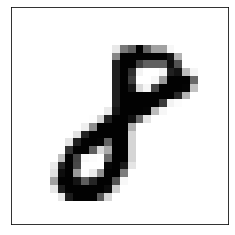

In [4]:
def show_digit(digit_array):
    plt.imshow(digit_array.reshape(28, 28), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[31])

## Random numbers in JAX

Maybe it's time to quickly talk about random numbers in JAX. They are generated differently than in Numpy. The main reason for this is to make it easier to paralellize random number generation over multiple devices. To generate random numbers, a Pseudo Random Number Generator (PRNG) Key needs to be defined from a seed:

In [5]:
prng = jax.random.PRNGKey(42)

now, to generate random numbers, the key first needs to be split into a key to use later and a key to use right now:

In [6]:
prng, key = jax.random.split(prng, 2)
jax.random.normal(key, (3,3))

DeviceArray([[-1.6652092 ,  0.23443979, -0.24498989],
             [ 0.44707215, -0.37714297,  0.28259823],
             [-0.11017016,  0.5699527 ,  0.33960482]], dtype=float32)

This procedure is repeated every time a new random array needs to be generated.

## Model

Let's make a simple three layer fully connected neural network. Due to JAX's functional nature it's often good practice (and a lot easier) to keep the model parameters together in a dictionary:

In [7]:
prng, w1key, b1key, w2key, b2key, w3key, b3key = jax.random.split(prng, 7)
num_hidden1 = 2048
num_hidden2 = 1024
params = dict(
    w1 = 1e-2*jax.random.normal(w1key, (num_pixels, num_hidden1)),
    b1 = 1e-2*jax.random.normal(b1key, (1, num_hidden1)),
    w2 = 1e-2*jax.random.normal(w2key, (num_hidden1, num_hidden2)),
    b2 = 1e-2*jax.random.normal(b2key, (1, num_hidden2)),
    w3 = 1e-2*jax.random.normal(w3key, (num_hidden2, num_labels)),
    b3 = 1e-2*jax.random.normal(b3key, (1, num_labels)),
)

In [8]:
@jax.jit
def forward(params, x):
    x = jax.nn.relu(x@params["w1"] + params["b1"])
    x = jax.nn.relu(x@params["w2"] + params["b2"])
    x = x@params["w3"] + params["b3"]
    return x

## Train

We use the categorical cross entropy loss for training the model. We define this loss function ourselves  as JAX does not off loss primitives (try to figure out what's going on!). For this we use both [jax.jit](https://jax.readthedocs.io/en/latest/jax.html?highlight=jit#jax.jit) and [jax.vmap](https://jax.readthedocs.io/en/latest/jax.html?highlight=jit#jax.vmap).

In [9]:
@jax.jit
def xeloss(x, y):
    _elementwise_xeloss = jax.vmap(lambda x, y: -jax.nn.log_softmax(x)[y])
    return _elementwise_xeloss(x, y).mean()

It's also useful to define an accuracy function...

In [10]:
@jax.jit
def accuracy(x, y):
    return 100*(jnp.argmax(x, 1) == y).mean()

Due to the functional nature of JAX, it's also useful to define a forward function that yields just the loss (in stead of the logits).

In [11]:
@jax.jit
def lossforward(params, x, y):
    x = forward(params, x)
    loss = xeloss(x, y)
    return loss

As optimizer we could use a Gradient Descent optimizer [with or without decaying learning rate] or one of the more sophisticated (and easier to optimize) optimizers like Adam or RMSProp. We're going for the adam optimizer.

In [12]:
# optimizer
learning_rate = 0.001
optim_init, optim_update, optim_params = jax.experimental.optimizers.adam(learning_rate)
optim_state = optim_init(params)

This is where the functional nature of JAX shows itself again... as can be seen above, creating an optimizer just creates three functions: an initialization function with which to initialize the optimizer state, an update function which will update the optimizer state (and with it the model parameters). The third function that's being returned will give the model parameters given the optimizer state.

given all this, we can define a single training step:

In [13]:
@jax.jit
def train_step(step, optim_state, x, y):
    params = optim_params(optim_state)
    loss, grads = jax.value_and_grad(lossforward)(params, x, y)
    optim_state = optim_update(step, grads, optim_state)
    return loss, optim_state

Finally, we can start the training:

In [14]:
history = []
batch_size = 100
num_steps = 2000
for step in range(num_steps):
    if step%200 == 0 or step == num_steps - 1:
        valid_logits = forward(optim_params(optim_state), valid_values)
        valid_loss = xeloss(valid_logits, valid_labels)
        valid_accuracy = accuracy(valid_logits, valid_labels)
        history.append((step, valid_loss, valid_accuracy))
        print(f"Step {step:5.0f}\t Valid. Acc. = {valid_accuracy:5.2f}")
    prng, key = jax.random.split(prng)
    idxs = jax.random.randint(key, (batch_size,), 0, train_size)
    x = train_values[idxs]
    y = train_labels[idxs]
    loss, optim_state = train_step(step, optim_state, x, y)

Step     0	 Valid. Acc. = 11.00
Step   200	 Valid. Acc. = 94.14
Step   400	 Valid. Acc. = 96.26
Step   600	 Valid. Acc. = 96.38
Step   800	 Valid. Acc. = 97.06
Step  1000	 Valid. Acc. = 97.47
Step  1200	 Valid. Acc. = 97.26
Step  1400	 Valid. Acc. = 97.32
Step  1600	 Valid. Acc. = 97.75
Step  1800	 Valid. Acc. = 97.68
Step  1999	 Valid. Acc. = 97.50


We can visualize the training history:

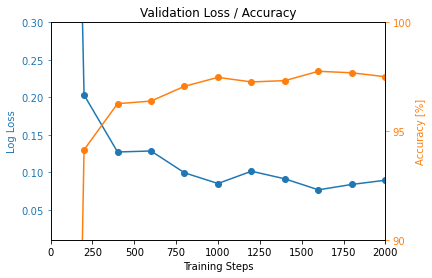

In [15]:
steps, loss, acc = zip(*history)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
plt.ylim(90,100)
plt.yticks([90,95,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
m = 1.1*max(loss)
plt.ylim(0.01, 0.3)

plt.xlim(0, (max(steps)+100)//100*100)
plt.xlabel('Training Steps')
plt.title('Validation Loss / Accuracy')
plt.show()

## Test

Finally, the accuracy on the test set can be evaluated:

In [16]:
params = optim_params(optim_state)
test_logits = forward(params, test_values)
test_accuracy = accuracy(test_logits, test_labels)
print(f'Test Accuracy = {test_accuracy:5.2f}')

Test Accuracy = 97.51


Visualize an example

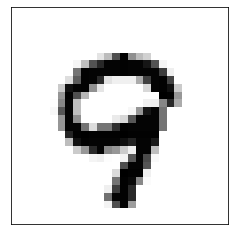

prediction=9	target=9


In [17]:
N = 315
show_digit(test_values[N])
test_logits = forward(params, test_values[N:N+1])
prediction = jnp.argmax(test_logits[0]).item()
target = test_labels[N].item()
print(f'prediction={prediction}\ttarget={target}')

That's it! A very simple example on how to use JAX. 